In [87]:
!pip install pystan
!pip install fbprophet
import fbprophet
from fbprophet import Prophet
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
print(os.getcwd())
import matplotlib.pyplot as plt


from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content


In [88]:
data = pd.read_excel("Demand Planning- Assignment.xlsx",sheet_name = "Data", skiprows=2)

def transform_raw_data(df):
    df.columns = df.iloc[0,:]
    df =df.iloc[2:,2:df.shape[1]-1].reset_index(drop = True).set_index("Hour")
    col_map = df.columns
    df = df.T
    df.reset_index(inplace = True)
    df.rename({0: "Date2"}, inplace = True, axis=1)
    df.head()
    df =df.melt(id_vars=["Date2"], 
            var_name="hour", 
            value_name="Sales")
    return df,col_map

df1,cols_for_mapping = transform_raw_data(data)
df1.head()

,Date2,hour,Sales
0,6-Sep,7,5
1,7-Sep,7,6
2,8-Sep,7,8
3,9-Sep,7,15
4,10-Sep,7,8


In [89]:
cols_for_mapping

Index(['6-Sep', '7-Sep', '8-Sep', '9-Sep', '10-Sep', '11-Sep', '12-Sep',
       '13-Sep', '14-Sep', '15-Sep', '16-Sep', '17-Sep', '18-Sep', '19-Sep',
       '20-Sep', '21-Sep', '22-Sep', '23-Sep', '24-Sep', '25-Sep', '26-Sep',
       '27-Sep', '28-Sep', '29-Sep', '30-Sep', '1-Oct', '2-Oct', '3-Oct',
       '4-Oct', '5-Oct', '6-Oct', '7-Oct', '8-Oct', '9-Oct', '10-Oct',
       '11-Oct', '12-Oct', '13-Oct', '14-Oct', '15-Oct', '16-Oct', '17-Oct',
       '18-Oct', '19-Oct', '20-Oct', '21-Oct', '22-Oct', '23-Oct', '24-Oct'],
      dtype='object', name=0)

In [90]:

def create_template(sd, ed, hours_st, hours_et):
    tm =pd.Series(pd.date_range(start= sd,end=ed))
    temp = pd.concat([tm, pd.Series(cols_for_mapping)], axis =1)
    temp.columns = ["Date1", "Date2"]
    temp['key'] =0
    # date_list
    hours = pd.DataFrame({'hour':list((range(hours_st, hours_et)))})
    hours["key"] = 0
    temp =  temp.merge(hours,on='key', how='outer')
    return temp

temp_df = create_template(sd = "2021-09-06", ed = "2021-10-24", hours_st =0, hours_et = 24)

temp_df.drop(columns = ["key"], inplace = True)
temp_df = temp_df.merge(df1, on = ["Date2", "hour"], how = "left" )
temp_df["Sale_hour"] = np.where(temp_df.Sales.isnull(), 0,1)
temp_df.Sales = temp_df.Sales.fillna(0)
temp_df.drop("Date2", axis =1, inplace = True)
temp_df["ds"] = pd.to_datetime(temp_df['Date1']+pd.to_timedelta(temp_df['hour'],unit='h'))
temp_df['weekday'] = temp_df['ds'].dt.dayofweek
temp_df["Sunday_flag"] = np.where(temp_df['weekday'] ==6,1, 0)
temp_df["Public_holiday_flag"] = np.where(temp_df.Date1.isin(['2021-09-10', '2021-10-02','2021-10-15','2021-10-19']),1, 0)
temp_df.head(10)

,Date1,hour,Sales,Sale_hour,ds,weekday,Sunday_flag,Public_holiday_flag
0,2021-09-06,0,0,0,2021-09-06 00:00:00,0,0,0
1,2021-09-06,1,0,0,2021-09-06 01:00:00,0,0,0
2,2021-09-06,2,0,0,2021-09-06 02:00:00,0,0,0
3,2021-09-06,3,0,0,2021-09-06 03:00:00,0,0,0
4,2021-09-06,4,0,0,2021-09-06 04:00:00,0,0,0
5,2021-09-06,5,0,0,2021-09-06 05:00:00,0,0,0
6,2021-09-06,6,0,0,2021-09-06 06:00:00,0,0,0
7,2021-09-06,7,5,1,2021-09-06 07:00:00,0,0,0
8,2021-09-06,8,14,1,2021-09-06 08:00:00,0,0,0
9,2021-09-06,9,21,1,2021-09-06 09:00:00,0,0,0


In [91]:
temp_df = temp_df[temp_df['Sale_hour']==1]
final_df = temp_df[['ds', 'Sales',	'Sunday_flag', 'Public_holiday_flag']]
final_df.rename(columns = {"Sales":"y"}, inplace = True)
train=final_df[final_df['ds'] < '2021-10-11']
test=final_df[(final_df['ds'] >= '2021-10-11')]
print(train.shape)
print(test.shape)
final_df.head(10)

(455, 4)
(182, 4)


,ds,y,Sunday_flag,Public_holiday_flag
7,2021-09-06 07:00:00,5,0,0
8,2021-09-06 08:00:00,14,0,0
9,2021-09-06 09:00:00,21,0,0
10,2021-09-06 10:00:00,16,0,0
11,2021-09-06 11:00:00,25,0,0
12,2021-09-06 12:00:00,33,0,0
13,2021-09-06 13:00:00,29,0,0
14,2021-09-06 14:00:00,31,0,0
15,2021-09-06 15:00:00,31,0,0
16,2021-09-06 16:00:00,31,0,0


Prophet filtered table

In [92]:

from google.colab import files
final_df.to_csv('ts_data.csv') 
files.download('ts_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

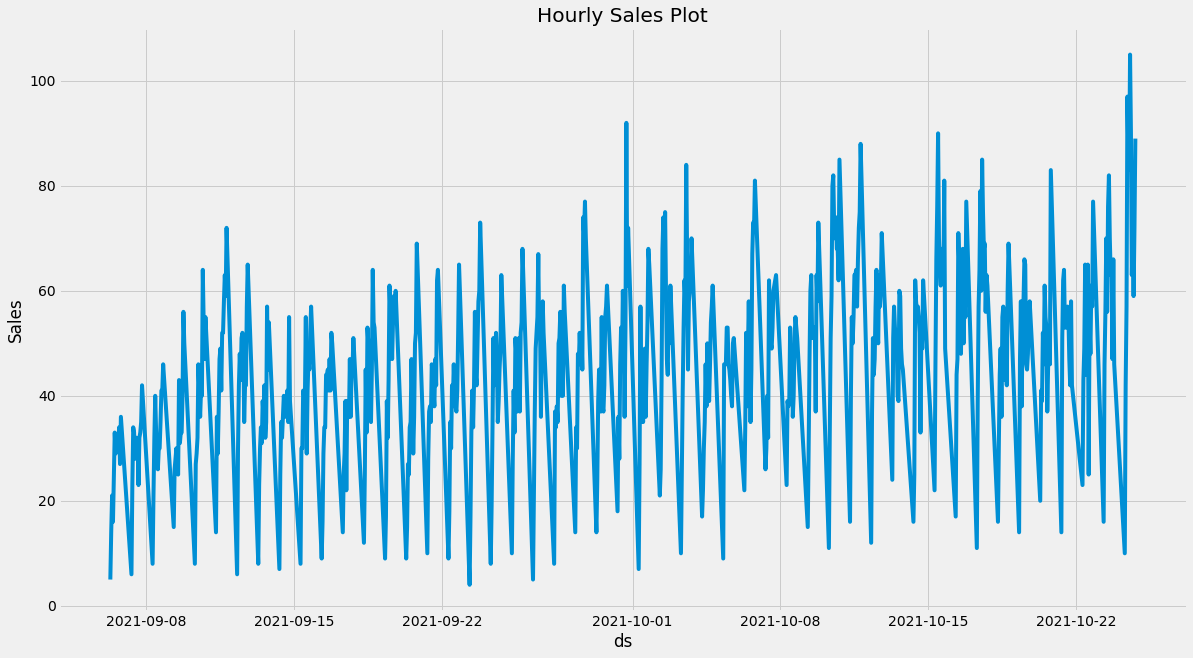

In [62]:
plt.style.use("fivethirtyeight")
 
plt.figure(figsize=(18, 10))
plt.xlabel("ds")
plt.ylabel("Sales")
plt.title("Hourly Sales Plot") 
plt.plot(temp_df.ds,temp_df.Sales)
plt.show()

In [6]:
# final_df = temp_df[['ds', 'Sales','Sale_hour'	,	'Sunday_flag', 'Public_holiday_flag']]
# final_df = temp_df[['ds', 'Sales',	'Sunday_flag', 'Public_holiday_flag']]
# final_df.rename(columns = {"Sales":"y"}, inplace = True)
# final_df.head()

,ds,y,Sunday_flag,Public_holiday_flag
7,2021-09-06 07:00:00,5,0,0
8,2021-09-06 08:00:00,14,0,0
9,2021-09-06 09:00:00,21,0,0
10,2021-09-06 10:00:00,16,0,0
11,2021-09-06 11:00:00,25,0,0


In [95]:
# train=final_df[final_df['ds'] < '2021-10-11']
# test=final_df[(final_df['ds'] >= '2021-10-11')]
# print(train.shape)
# print(test.shape)
test.head()

,ds,y,Sunday_flag,Public_holiday_flag
847,2021-10-11 07:00:00,16,0,0
848,2021-10-11 08:00:00,40,0,0
849,2021-10-11 09:00:00,55,0,0
850,2021-10-11 10:00:00,50,0,0
851,2021-10-11 11:00:00,55,0,0


In [69]:
m = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True)
#m.add_regressor('Sale_hour',standardize=False)
# m.add_regressor('Sunday_flag',standardize=False, mode = 'multiplicative')
# m.add_regressor("Public_holiday_flag",standardize=False, mode = 'multiplicative') 


In [70]:
m.fit(train)



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [71]:
test[['ds']].tail()

,ds
1167,2021-10-24 15:00:00
1168,2021-10-24 16:00:00
1169,2021-10-24 17:00:00
1170,2021-10-24 18:00:00
1171,2021-10-24 19:00:00


In [72]:
# future = m.make_future_dataframe(periods=336, freq='H')
future = final_df[['ds']]

future.tail()

,ds
1167,2021-10-24 15:00:00
1168,2021-10-24 16:00:00
1169,2021-10-24 17:00:00
1170,2021-10-24 18:00:00
1171,2021-10-24 19:00:00


In [14]:
# # future['Sale_hour'] = final_df['Sale_hour']
# future['Sunday_flag'] = final_df['Sunday_flag']
# future['Public_holiday_flag'] = final_df['Public_holiday_flag']

In [73]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
632,2021-10-24 15:00:00,63.940083,48.448363,79.372349
633,2021-10-24 16:00:00,66.008353,50.092487,81.470644
634,2021-10-24 17:00:00,71.114654,54.934588,86.021306
635,2021-10-24 18:00:00,75.858957,60.203166,90.584222
636,2021-10-24 19:00:00,78.531272,62.828931,93.743983


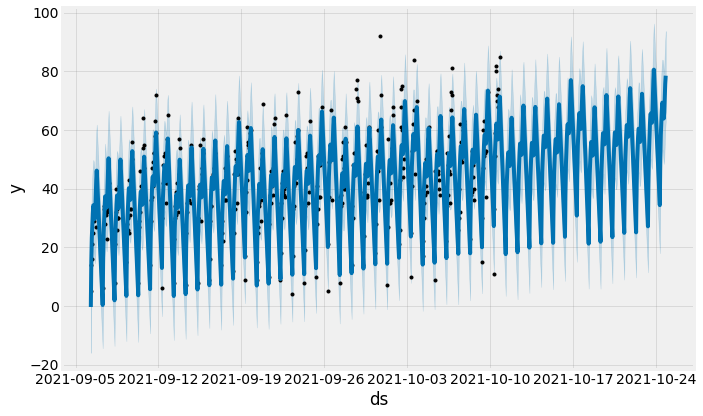

In [74]:
fig1 = m.plot(forecast)

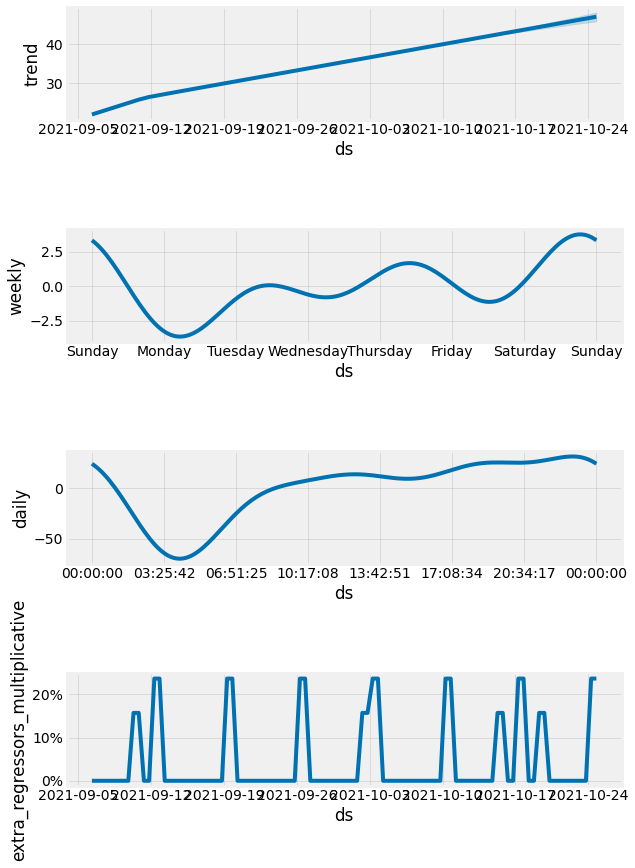

In [17]:
fig2 = m.plot_components(forecast)

In [18]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [75]:
predictions = forecast[['ds','yhat']].iloc[455:,:]
pred = predictions['yhat']
print(test['y'].mean())
print(rmse( test['y'], pred))
print(mape(test['y'], pred))
# mean_absolute_percentage_error(test['y'], pred)

54.456043956043956
12.394983660376896
21.424694901058736


In [23]:
op1 = pd.concat([test['ds'].reset_index(drop = True), test['y'].reset_index(drop = True), pred.reset_index(drop = True)], axis=1)
# test['ds'].reset_index(drop = True), test['y'].reset_index(drop = True),
from google.colab import files
op1.to_csv('output1.csv') 
files.download('output1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predict Future

In [67]:
temp =pd.DataFrame(pd.date_range(start= "2021-10-25",end="2021-11-08"), columns = ["Date"])
temp['key'] =0
hours = pd.DataFrame({'hour':list((range(7, 20)))})
hours["key"] = 0
forecast_df =  temp.merge(hours,on='key', how='outer')

forecast_df.drop(columns = ["key"], inplace = True)
forecast_df["ds"] = pd.to_datetime(forecast_df['Date']+pd.to_timedelta(forecast_df['hour'],unit='h'))
# forecast_df.tail(2)
# temp

future = forecast_df[['ds']]

future.tail()


,ds
190,2021-11-08 15:00:00
191,2021-11-08 16:00:00
192,2021-11-08 17:00:00
193,2021-11-08 18:00:00
194,2021-11-08 19:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

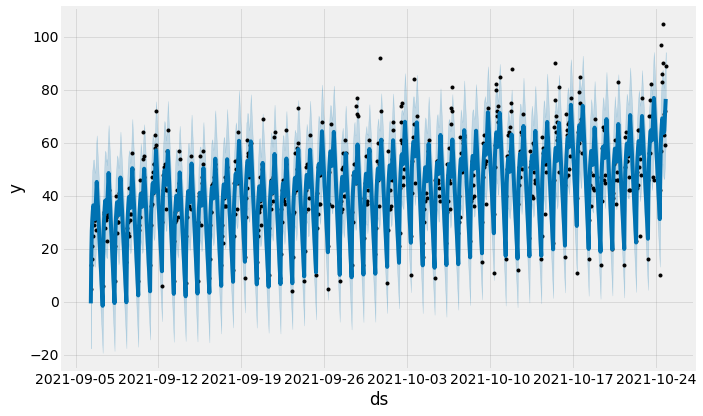

In [77]:
m = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True)
m.fit(final_df)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

#Forecast
fb_op = pd.concat([forecast_df['ds'].reset_index(drop = True), pred.reset_index(drop = True)], axis=1)
# test['ds'].reset_index(drop = True), test['y'].reset_index(drop = True),
from google.colab import files
fb_op.to_csv('fb_forecast.csv') 
files.download('fb_forecast.csv')

ARIMA

In [85]:
# ARIMA has AR, MA , int. AR: previous values, MA: past errors, integ : diff
!pip install pmdarima
# from typing import Literal
from statsmodels.tsa.arima_model import ARIMA
# import pmdarima as pm
from pmdarima import auto_arima
stepwise_fit = auto_arima(final_df.y, trace = True, suppress_warnings = True)
stepwise_fit.summary()

#minimize AIC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
# ARIMA(0,1,1)
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train.y, order =(1,1,3)).fit()
model.summary()

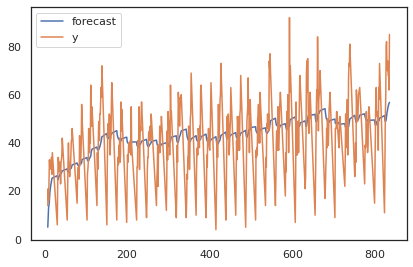

ds
2021-10-11 07:00:00    58.178096
2021-10-11 08:00:00    58.247309
2021-10-11 09:00:00    58.316523
2021-10-11 10:00:00    58.385737
2021-10-11 11:00:00    58.454950
2021-10-11 12:00:00    58.524164
2021-10-11 13:00:00    58.593378
2021-10-11 14:00:00    58.662591
2021-10-11 15:00:00    58.731805
2021-10-11 16:00:00    58.801018
2021-10-11 17:00:00    58.870232
2021-10-11 18:00:00    58.939446
2021-10-11 19:00:00    59.008659
2021-10-12 07:00:00    59.077873
2021-10-12 08:00:00    59.147087
2021-10-12 09:00:00    59.216300
2021-10-12 10:00:00    59.285514
2021-10-12 11:00:00    59.354728
2021-10-12 12:00:00    59.423941
2021-10-12 13:00:00    59.493155
2021-10-12 14:00:00    59.562368
2021-10-12 15:00:00    59.631582
2021-10-12 16:00:00    59.700796
2021-10-12 17:00:00    59.770009
2021-10-12 18:00:00    59.839223
2021-10-12 19:00:00    59.908437
2021-10-13 07:00:00    59.977650
2021-10-13 08:00:00    60.046864
2021-10-13 09:00:00    60.116077
2021-10-13 10:00:00    60.185291
2021-10

In [127]:
# model.forecast(20)
model.plot_predict()
plt.show()
model.forecast(60)[0]

y_pred = pd.Series(model.forecast(182)[0], index = test.ds)
y_pred

In [129]:
# plt.plot(test.y)
# plt.plot(y_pred)
# plt.show()

pd.DataFrame({"actual": test.y, 
              "predicted": model.forecast(182)[0]})

,actual,predicted
847,16,58.178096
848,40,58.247309
849,55,58.316523
850,50,58.385737
851,55,58.454950
852,63,58.524164
853,63,58.593378
854,64,58.662591
855,57,58.731805
856,66,58.801018


In [120]:
# predictions = forecast[['ds','yhat']].iloc[455:,:]
# pred = predictions['yhat']
print(test['y'].mean())
print(rmse( test['y'], y_pred))
print(mape(test['y'], y_pred))

54.456043956043956
19.644721445268416
47.184146563747895


Exponential Smoothing

In [18]:
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [103]:

train_ets = train.copy()
train_ets = train_ets.iloc[:,:2]
train_ets.set_index("ds", inplace = True)
# train_ets

test_ets = test.copy()
test_ets = test_ets.iloc[:,:2]
test_ets.info()
test_ets.set_index("ds", inplace = True)
# test_ets

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 847 to 1171
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      182 non-null    datetime64[ns]
 1   y       182 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.3 KB


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9


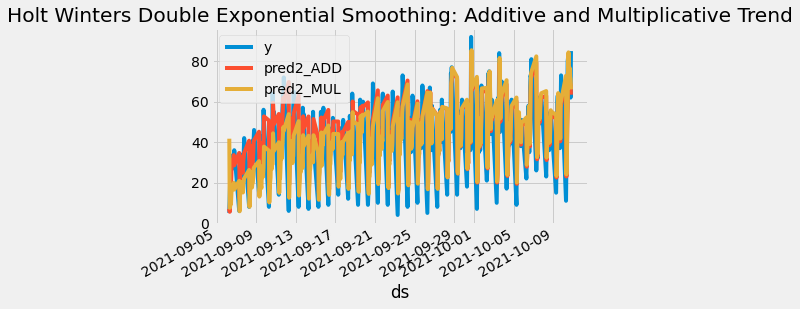

In [51]:
train_ets['pred2_ADD'] = ExponentialSmoothing(train_ets['y'],trend='add').fit(smoothing_level=0.8,use_brute=True).fittedvalues
train_ets['pred2_MUL'] = ExponentialSmoothing(train_ets['y'],trend='mul').fit(smoothing_level=0.8,use_brute=True).fittedvalues
train_ets[['y','pred2_ADD','pred2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend')
print(alpha)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


54.456043956043956
15.71966746887799
25.454029749048914


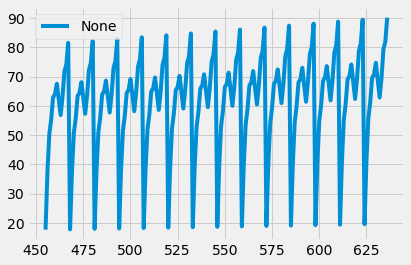

In [101]:
ets_model = ExponentialSmoothing(train_ets['y'],trend='mul', seasonal = 'mul',seasonal_periods=13).fit(smoothing_level=0.5,use_brute=True)
test_predictions = ets_model.forecast(182)
test_predictions
# len(test)

# test_ets['y'].plot(legend=True)
test_predictions.plot(legend=True)
len(test_predictions)

print(test['y'].mean())
print(rmse( test['y'], test_predictions))
print(mape(test['y'], test_predictions))

In [102]:
ets3 = pd.concat([test['ds'].reset_index(drop = True), test['y'].reset_index(drop = True), test_predictions.reset_index(drop = True)], axis=1)
ets3.columns = ['time', 'actual', 'predicted']
from google.colab import files
ets3.to_csv('output3.csv') 
files.download('output3.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>